In [16]:
import numpy as np
import pandas as pd
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [18]:
# URLs to the datasets
url_tourism = "https://raw.githubusercontent.com/aidulfitri/WesataOne-ML/main/data/tourism_with_id.csv"
url_rating = "https://raw.githubusercontent.com/aidulfitri/WesataOne-ML/main/data/tourism_rating.csv"


In [19]:
# Reading the datasets
df_places = pd.read_csv(url_tourism)
rating_df = pd.read_csv(url_rating)

In [20]:
# Selecting necessary columns
data_place = df_places[["Place_Id", "Place_Name", "Category", "City", "Description", "Rating"]]
rating_df = rating_df[["User_Id", "Place_Id", "Place_Ratings"]]

In [21]:
data_place.drop_duplicates(inplace=True)
data_place.dropna(inplace=True)

<ipython-input-21-c3270c075c9c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_place.drop_duplicates(inplace=True)
<ipython-input-21-c3270c075c9c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_place.dropna(inplace=True)


In [22]:
# One-hot encode Category and City features
data_place = pd.get_dummies(data_place, columns=["Category", "City"])


In [23]:
# Preparing the feature set
place_features = data_place.drop(columns=["Place_Id", "Place_Name", "Description", "Rating"]).values


In [26]:
# Standardize features
scaler = StandardScaler()
place_features_scaled = scaler.fit_transform(place_features)

In [27]:
# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(place_features_scaled, data_place["Rating"], test_size=0.2, random_state=1)


In [28]:
# Building the TensorFlow model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])

In [29]:
# Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])


In [30]:
# Training the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)


Epoch 1/20
9/9 [==============================] - 1s 29ms/step - loss: 17.9528 - mse: 17.9528 - val_loss: 15.4404 - val_mse: 15.4404
Epoch 2/20
9/9 [==============================] - 0s 7ms/step - loss: 13.7210 - mse: 13.7210 - val_loss: 11.7005 - val_mse: 11.7005
Epoch 3/20
9/9 [==============================] - 0s 6ms/step - loss: 9.8609 - mse: 9.8609 - val_loss: 8.1943 - val_mse: 8.1943
Epoch 4/20
9/9 [==============================] - 0s 8ms/step - loss: 6.4166 - mse: 6.4166 - val_loss: 5.0415 - val_mse: 5.0415
Epoch 5/20
9/9 [==============================] - 0s 8ms/step - loss: 3.6371 - mse: 3.6371 - val_loss: 2.6002 - val_mse: 2.6002
Epoch 6/20
9/9 [==============================] - 0s 7ms/step - loss: 1.7613 - mse: 1.7613 - val_loss: 1.1576 - val_mse: 1.1576
Epoch 7/20
9/9 [==============================] - 0s 7ms/step - loss: 0.9021 - mse: 0.9021 - val_loss: 0.5308 - val_mse: 0.5308
Epoch 8/20
9/9 [==============================] - 0s 6ms/step - loss: 0.5138 - mse: 0.5138 - va

#Recommendation for Users

In [31]:
# Function to get user profile from rated places
def get_user_profile(user_id, rating_df, data_place, place_features):
    user_ratings = rating_df[rating_df['User_Id'] == user_id]
    rated_places = user_ratings.merge(data_place, on='Place_Id')
    rated_place_ids = rated_places['Place_Id'].values
    rated_place_features = place_features[data_place['Place_Id'].isin(rated_place_ids)]
    user_profile = rated_place_features.mean(axis=0)
    return user_profile

In [36]:
def recommend_places(user_id, rating_df, data_place, place_features, model, city_filter=None, category_filter=None):
    user_profile = get_user_profile(user_id, rating_df, data_place, place_features)
    user_profile = user_profile.reshape(1, -1)


    predicted_ratings = model.predict(place_features)
    data_place['predicted_rating'] = predicted_ratings

    if city_filter:
        city_col = 'City_' + city_filter
        if city_col in data_place.columns:
            data_place = data_place[data_place[city_col] == 1]
    if category_filter:
        category_col = 'Category_' + category_filter
        if category_col in data_place.columns:
            data_place = data_place[data_place[category_col] == 1]

    recommendations = data_place.sort_values(by='predicted_rating', ascending=False).head(20)
    recommendations = recommendations[['Place_Name', 'City_' + city_filter, 'Description', 'predicted_rating']]

    return recommendations


In [37]:
user_id = 1
city_filter = 'Jakarta'
category_filter = 'Budaya'

recommendations = recommend_places(user_id, rating_df, data_place, place_features_scaled, model, city_filter, category_filter)
print(recommendations)


14/14 [==============================] - 0s 2ms/step
                        Place_Name  City_Jakarta  \
31                    Setu Babakan          True   
63  Museum Sasmita Loka Ahmad Yani          True   
62     Museum Kebangkitan Nasional          True   
0                 Monumen Nasional          True   
49                 Museum Joang 45          True   
73             Museum Tengah Kebun          True   
72                 Museum Perangko          True   
69           Perpustakaan Nasional          True   
68                 Freedom Library          True   
65            Museum Layang-layang          True   
64         Museum Basoeki Abdullah          True   
60                 Tugu Proklamasi          True   
59                  Museum Tekstil          True   
58            Museum Sumpah Pemuda          True   
52                  Rumah Sipitung          True   
51                    Kampung Cina          True   
48           Galeri Indonesia Kaya          True   
1          

# Recommendations on the main display

In [38]:
def recommend_popular_places(data_place, num_recommendations=20):
    popular_places = data_place.sort_values(by='Rating', ascending=False).head(num_recommendations)

    recommendations = popular_places[['Place_Name', 'Description', 'Rating']]

    return recommendations

# Contoh penggunaan untuk pengguna baru
recommendations_for_new_user = recommend_popular_places(data_place)
print(recommendations_for_new_user)


                                    Place_Name  \
45                            Pulau Semak Daun   
279          Gereja Tiberias Indonesia Bandung   
371                   Gua Maria Kerep Ambarawa   
410                  Masjid Muhammad Cheng Hoo   
411                   Masjid Nasional Al-Akbar   
305                          Sungai Palayangan   
277              Masjid Daarut Tauhiid Bandung   
123               Kauman Pakualaman Yogyakarta   
287                          Masjid Salman ITB   
297                             Gunung Lalakon   
48                       Galeri Indonesia Kaya   
22                             Gereja Katedral   
278          Masjid Agung Trans Studio Bandung   
69                       Perpustakaan Nasional   
263       Gereja Katedral Santo Petrus Bandung   
347                            Pura Giri Natha   
247                       NuArt Sculpture Park   
91                  Nol Kilometer Jl.Malioboro   
94          Desa Wisata Sungai Code Jogja Kota   


#Usage example for new users

In [40]:
def recommend_popular_places_with_filter(data_place, city_filter=None, category_filter=None, num_recommendations=20):
    filtered_places = data_place

    if city_filter:
        filtered_places = filtered_places[filtered_places['City_' + city_filter] == 1]
    if category_filter:
        filtered_places = filtered_places[filtered_places['Category_' + category_filter] == 1]

    # Urutkan tempat berdasarkan rating tertinggi
    popular_places = filtered_places.sort_values(by='Rating', ascending=False).head(num_recommendations)

    # Pilih kolom yang diperlukan
    recommendations = popular_places[['Place_Name', 'Description', 'Rating']]

    return recommendations

In [41]:
# Contoh penggunaan untuk pengguna baru dengan filter kategori dan wilayah
city_filter = 'Jakarta'
category_filter = 'Budaya'

recommendations_for_new_user = recommend_popular_places_with_filter(data_place, city_filter, category_filter)
print(recommendations_for_new_user)

                          Place_Name  \
48             Galeri Indonesia Kaya   
69             Perpustakaan Nasional   
43            Monumen Selamat Datang   
73               Museum Tengah Kebun   
17             Museum Bank Indonesia   
64           Museum Basoeki Abdullah   
63    Museum Sasmita Loka Ahmad Yani   
62       Museum Kebangkitan Nasional   
60                   Tugu Proklamasi   
58              Museum Sumpah Pemuda   
39         Galeri Nasional Indonesia   
49                   Museum Joang 45   
1                           Kota Tua   
47              Taman Ismail Marzuki   
0                   Monumen Nasional   
23                   Museum Nasional   
37  Istana Negara Republik Indonesia   
16                 Museum Fatahillah   
81             Museum Satria Mandala   
52                    Rumah Sipitung   

                                          Description  Rating  
48  Galeri Indonesia Kaya (disingkat GIK) adalah r...     4.8  
69  Perpustakaan Nasional adala

# Plot

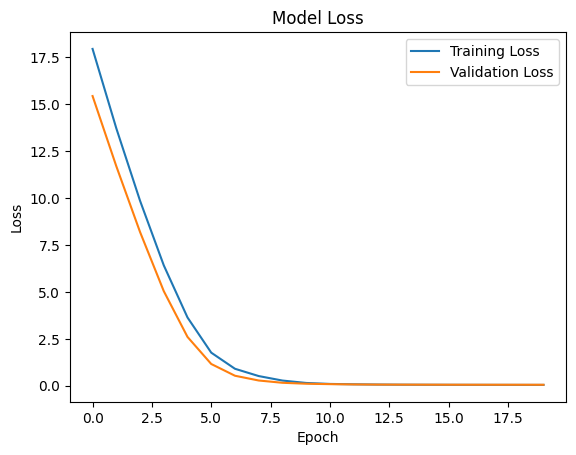

In [42]:
import matplotlib.pyplot as plt

# Ambil data loss dari history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [43]:
# Simpan model dalam format .h5
model.save("wesataone.h5")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [44]:
from google.colab import files

# Unduh file .h5
files.download("wesataone.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [52]:
# Simpan arsitektur model dalam format .json
model_json = model.to_json()
with open("modelwesataone_architecture.json", "w") as json_file:
    json_file.write(model_json)


In [53]:
# Unduh file .json
files.download("modelwesataone_architecture.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>